**Author**: Victor Teixidó López

In [1]:
!pip install -q transformers
!pip install -q datasets
!pip install -q torchvision
!pip install -q -U accelerate
!pip install -q -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 63.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk

import torch

from matplotlib.pyplot import plot

In [3]:
import gc

device = 'cuda'
gc.collect()
torch.cuda.empty_cache()

# Read data from csv

We are going to read the train, validation and test data obtained in the preprocessing notebook.

In [6]:
from datasets import Dataset, DatasetDict

# Read datasets
train_df = pd.read_csv('/content/drive/MyDrive/UNI/tfg/dataframes/PreprocessedTrainData.csv')
train_dataset = Dataset.from_pandas(train_df)

val_df = pd.read_csv('/content/drive/MyDrive/UNI/tfg/dataframes/PreprocessedValidationData.csv')
val_dataset = Dataset.from_pandas(val_df)

test_df = pd.read_csv('/content/drive/MyDrive/UNI/tfg/dataframes/PreprocessedTestData.csv')
test_dataset = Dataset.from_pandas(test_df)

# Combine datasets
raw_datasets = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

In [7]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['reviews', 'ratings'],
        num_rows: 71337
    })
    validation: Dataset({
        features: ['reviews', 'ratings'],
        num_rows: 17834
    })
    test: Dataset({
        features: ['reviews', 'ratings'],
        num_rows: 18708
    })
})

# HuggingFace model

We selected *bertweet-base-sentiment-analysis* from *finiteautomata* to make predictions for our data. Check the model [here](https://huggingface.co/finiteautomata/bertweet-base-sentiment-analysis).

In [8]:
checkpoint = "finiteautomata/bertweet-base-sentiment-analysis"

## Tokenization

After having all the data preprocessed and divided, we continue with their tokenization by words. We will use the tokenizer provided from the model selected.

In [9]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/338 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


In [10]:
from transformers import DataCollatorWithPadding

def tokenize_function(dataset):
  return tokenizer(dataset['reviews'], truncation=True, padding=True, return_tensors='pt')

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/71337 [00:00<?, ? examples/s]

Map:   0%|          | 0/17834 [00:00<?, ? examples/s]

Map:   0%|          | 0/18708 [00:00<?, ? examples/s]

In [11]:
tokenized_datasets = tokenized_datasets.remove_columns(['reviews'])
tokenized_datasets = tokenized_datasets.rename_column('ratings', 'labels')
tokenized_datasets.set_format("torch")
tokenized_datasets['train'].column_names

['labels', 'input_ids', 'token_type_ids', 'attention_mask']

In [12]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_datasets['train'], shuffle=True, batch_size=8, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_datasets['validation'], batch_size=8, collate_fn=data_collator
)

In [13]:
for batch in train_dataloader:
    break
{k: v.shape for k, v in batch.items()}

{'labels': torch.Size([8]),
 'input_ids': torch.Size([8, 128]),
 'token_type_ids': torch.Size([8, 128]),
 'attention_mask': torch.Size([8, 128])}

In [14]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

config.json:   0%|          | 0.00/949 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

In [15]:
from transformers import Trainer, TrainingArguments

args = TrainingArguments('test-trainer')
args.save_steps = 10000 # Avoid running out of Disk space in Colab

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    tokenizer=tokenizer,
)

In [16]:
trainer.train()

Step,Training Loss
500,0.669700
1000,0.575400
1500,0.558600
2000,0.542600
2500,0.566900
3000,0.569400
3500,0.586000
4000,0.526700
4500,0.535100
5000,0.516600


TrainOutput(global_step=26754, training_loss=0.4593111748134661, metrics={'train_runtime': 5584.393, 'train_samples_per_second': 38.323, 'train_steps_per_second': 4.791, 'total_flos': 1.4077291410346752e+16, 'train_loss': 0.4593111748134661, 'epoch': 3.0})

## Save the model

In [ ]:
#model.save('/content/drive/MyDrive/UNI/tfg/models/fine_tuned_model.h5')

## Predict test data

In [17]:
predictions = trainer.predict(tokenized_datasets['test'])
print(predictions.predictions.shape, predictions.label_ids.shape)

(18708, 3) (18708,)


## Process the results

In [18]:
from scipy.special import softmax

predicted_probs = [softmax(pred) for pred in predictions[0]]
predicted_probs = [[round(prob, 4) for prob in batch] for batch in predicted_probs]

predicted_ratings = [np.argmax(pred) for pred in predicted_probs]

## Save the results into a DataFrame

In [19]:
data = {
    'reviews': raw_datasets['test']['reviews'],
    'ratings': raw_datasets['test']['ratings'],
    'predicted_ratings': predicted_ratings,
    'predicted_probs': predicted_probs
}

results_df = pd.DataFrame(data)

In [20]:
results_df.head()

,reviews,ratings,predicted_ratings,predicted_probs
0,visit disneyland many time 60 hard enjoy park ...,1,2,"[0.0034, 0.0339, 0.9627]"
1,back soon 5 day 72 mile walk 3 pound lose wait...,2,2,"[0.0008, 0.0089, 0.9902]"
2,go see harry potter world amazing fan unbeliev...,2,2,"[0.0007, 0.0077, 0.9916]"
3,mean love disneylandbut unfortunately major ri...,2,2,"[0.0035, 0.0349, 0.9617]"
4,visit park 5 year ago excite rein act awesome ...,2,2,"[0.0037, 0.0363, 0.96]"


In [27]:
results_df.to_csv('/content/drive/MyDrive/UNI/tfg/dataframes/FineTunedModelData.csv', index=False)

## Read results from csv (if needed)

In [28]:
results_df = pd.read_csv('/content/drive/MyDrive/UNI/tfg/dataframes/FineTunedModelData.csv')
true_labels = results_df['ratings']
predicted_labels = results_df['predicted_ratings']
predicted_probs = results_df['predicted_probs']

# Model evaluation

## 3 classes classification

We will separate our data into 3 classes from the ratings we have:
- Negative (ratings with 1/2 stars)
- Neutral (ratings with 3 stars)
- Positve (ratings with 4/5 stars)

### Accuracy

In [23]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.86


### Confusion matrix

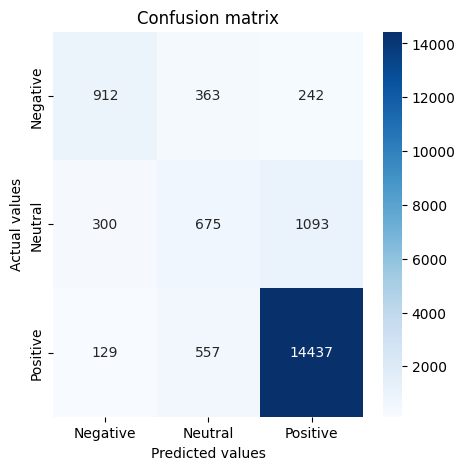

In [24]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(true_labels, predicted_labels)
conf_matrix_df = pd.DataFrame(conf_matrix,
                              index = ["Negative", "Neutral", "Positive"],
                              columns = ["Negative", "Neutral", "Positive"])

plt.figure(figsize=(5,5))
sns.heatmap(conf_matrix_df, cmap='Blues', annot=True, fmt='g')
plt.title("Confusion matrix")
plt.ylabel("Actual values")
plt.xlabel("Predicted values")
plt.show()

### Receiver Operating Characteristic (ROC) Curve

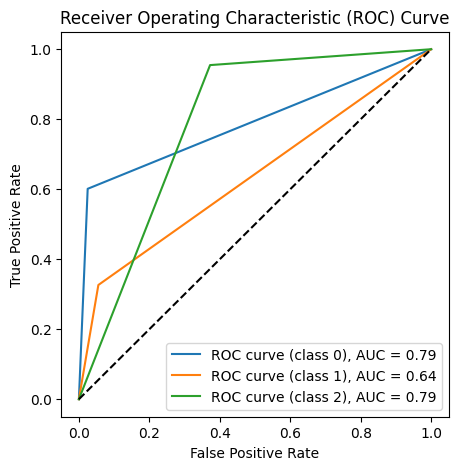


Overall AUC: 0.74


In [25]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Convert true and predicted labels to binary format for each class
true_labels_bin = label_binarize(true_labels, classes=[0, 1, 2])
predicted_labels_bin = label_binarize(predicted_labels, classes=[0, 1, 2])

fpr = dict()  # False positive rate
tpr = dict()  # True positive rate
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], predicted_labels_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(5, 5))

for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f"ROC curve (class {i}), AUC = {roc_auc[i]:.2f}")

plt.plot([0, 1], [0, 1], 'k--')  # Plot diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc='best')
plt.show()

# Calculate the overall AUC by averaging the AUCs of individual classes
overall_auc = sum(roc_auc.values()) / len(roc_auc)
print(f"\nOverall AUC: {overall_auc:.2f}")

### Precision, Recall and F1-score

In [26]:
from sklearn.metrics import classification_report

class_report = classification_report(true_labels, predicted_labels, target_names=["Negative", "Neutral", "Positive"])
print(class_report)

              precision    recall  f1-score   support

    Negative       0.68      0.60      0.64      1517
     Neutral       0.42      0.33      0.37      2068
    Positive       0.92      0.95      0.93     15123

    accuracy                           0.86     18708
   macro avg       0.67      0.63      0.65     18708
weighted avg       0.84      0.86      0.85     18708

